In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image
import IProgress

torch.cuda.empty_cache()

In [64]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [65]:
'''Load LUNA dataset'''

# import h5py 
# import numpy as np
# import skimage
# import torch
# from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
# f = h5py.File('all_patches.hdf5','r')
# f.keys()
# img = f['ct_slices'][:]  
# label = f['slice_class'][:] 
# f.close()
# print(np.shape(img))
# print('b',np.shape(label))
# skimage.io.imshow(img[120])
# print(label[120])
# batchsize=4

# class LungDataset(Dataset):
#     def __init__(self, img, label, transform=None):
#         self.img = img
#         self.label = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         image = PIL_image = Image.fromarray(self.img[idx]).convert('RGB')

#         if self.transform:
#             image = self.transform(image)
#         sample = {'img': image,
#                   'label': int(self.label[idx])}
#         return sample
    
# trainset = LungDataset(img, label, transform= val_transformer)
# valset = LungDataset(img, label, transform= val_transformer)
# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# modelname = 'medical_transfer'

'Load LUNA dataset'

In [66]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='../../Images-processed',
                              txt_COVID='../../Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='../../Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='../../Images-processed',
                              txt_COVID='../../Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='../../Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='../../Images-processed',
                              txt_COVID='../../Data-split/COVID/testCT_COVID.txt',
                              txt_NonCOVID='../../Data-split/NonCOVID/testCT_NonCOVID.txt',
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


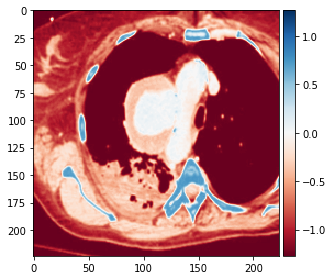

In [67]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [68]:
# mixup
'''Use mixup to do data augmentation'''

# def mixup_data(x, y, alpha=1.0, use_cuda=True):
#     '''Returns mixed inputs, pairs of targets, and lambda'''
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
# #         print('lam',lam)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
# #     print(pred)
# #     print(y_a)
# #     print('criterion',criterion(pred, y_a))
#     return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

'Use mixup to do data augmentation'

In [69]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [70]:
#val process is defined here

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [71]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [72]:
'''CheXNet pretrained model'''

# class DenseNet121(nn.Module):
#     """Model modified.

#     The architecture of our model is the same as standard DenseNet121
#     except the classifier layer which has an additional sigmoid function.

#     """
#     def __init__(self, out_size):
#         super(DenseNet121, self).__init__()
#         self.densenet121 = torchvision.models.densenet121(pretrained=True)
#         num_ftrs = self.densenet121.classifier.in_features
#         self.densenet121.classifier = nn.Sequential(
#             nn.Linear(num_ftrs, out_size),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.densenet121(x)
#         return x
  

# device = 'cuda'
# CKPT_PATH = 'model.pth.tar'
# N_CLASSES = 14

# DenseNet121 = DenseNet121(N_CLASSES).cuda()

# CKPT_PATH = './CheXNet/model.pth.tar'

# if os.path.isfile(CKPT_PATH):
#     checkpoint = torch.load(CKPT_PATH)        
#     state_dict = checkpoint['state_dict']
#     remove_data_parallel = False


#     pattern = re.compile(
#         r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
#     for key in list(state_dict.keys()):
#         match = pattern.match(key)
#         new_key = match.group(1) + match.group(2) if match else key
#         new_key = new_key[7:] if remove_data_parallel else new_key
#         new_key = new_key[7:]
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]


#     DenseNet121.load_state_dict(checkpoint['state_dict'])
#     print("=> loaded checkpoint")
# #     print(densenet121)
# else:
#     print("=> no checkpoint found")

# # for parma in DenseNet121.parameters():
# #         parma.requires_grad = False
# DenseNet121.densenet121.classifier._modules['0'] = nn.Linear(in_features=1024, out_features=2, bias=True)
# DenseNet121.densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# # print(DenseNet121)
# model = DenseNet121.to(device)

'CheXNet pretrained model'

In [73]:
'''DenseNet121 pretrained model from xrv'''

# class DenseNetModel(nn.Module):

#     def __init__(self):
#         """
#         Pass in parsed HyperOptArgumentParser to the model
#         :param hparams:
#         """
#         super(DenseNetModel, self).__init__()

#         self.dense_net = xrv.models.DenseNet(num_classes=2)
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, x):
#         logits = self.dense_net(x)
#         return logits
    
# model = DenseNetModel().cuda()
# modelname = 'DenseNet_medical'
# # print(model)

'DenseNet121 pretrained model from xrv'

In [74]:
'''ResNet18 pretrained'''
# import torchvision.models as models
# model = models.resnet18(pretrained=True).cuda()
# modelname = 'ResNet18'

'ResNet18 pretrained'

In [75]:
'''Dense121 pretrained'''
# import torchvision.models as models
# model = models.densenet121(pretrained=True).cuda()
# modelname = 'Dense121'
# pretrained_net = torch.load('model_backup/Dense121.pt')
# model.load_state_dict(pretrained_net)

'Dense121 pretrained'

In [76]:
### Dense169
import torchvision.models as models
# model = models.densenet169(pretrained=True).cuda()
# # # modelname = 'Dense169'

# """load MoCo pretrained model"""
# checkpoint = torch.load('new_data/save_model_dense/checkpoint_luna_covid_moco.pth.tar')
# # # # print(checkpoint.keys())
# # # # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
# #         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'classifier.0.weight':
#         new_key = 'classifier.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.0.bias':
#         new_key = 'classifier.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
#         del state_dict[key]
# state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
# state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
# model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

In [32]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('model_backup/Dense169.pt')
# pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
pretrained_net = torch.load('model_backup/medical_transfer/medical_transfer_None_LUNA_moco_covid_moco.pt')


model.load_state_dict(pretrained_net)

modelname = 'Dense169_ssl_luna_moco'

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/relkochta/.cache/torch/checkpoints/densenet169-b2777c0a.pth


ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [31]:
'''ResNet50 pretrained'''

# import torchvision.models as models
# model = models.resnet50(pretrained=True).cuda()

# checkpoint = torch.load('new_data/save_model/checkpoint.pth.tar')
# # print(checkpoint.keys())
# # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
#         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'fc.0.weight':
#         new_key = 'fc.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.0.bias':
#         new_key = 'fc.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.2.weight' or key == 'fc.2.bias':
#         del state_dict[key]
# state_dict['fc.weight'] = state_dict['fc.weight'][:1000,:]
# state_dict['fc.bias'] = state_dict['fc.bias'][:1000]
# # print(state_dict.keys())

# # print(state_dict)
# # pattern = re.compile(
# #         r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
# #     for key in list(state_dict.keys()):
# #         match = pattern.match(key)
# #         new_key = match.group(1) + match.group(2) if match else key
# #         new_key = new_key[7:] if remove_data_parallel else new_key
# #         new_key = new_key[7:]
# #         state_dict[new_key] = state_dict[key]
# #         del state_dict[key]
    
# # model.load_state_dict(checkpoint['state_dict'])
    
# # # modelname = 'ResNet50'
# modelname = 'ResNet50_ssl'

'ResNet50 pretrained'

In [32]:
'''VGGNet pretrained'''
# import torchvision.models as models
# model = models.vgg16(pretrained=True)
# model = model.cuda()
# modelname = 'vgg16'

'VGGNet pretrained'

In [33]:
'''efficientNet pretrained'''

# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
# model = model.cuda()
# modelname = 'efficientNet-b0'


# model = EfficientNet.from_name('efficientnet-b1').cuda()
# modelname = 'efficientNet_random'

'efficientNet pretrained'

In [35]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 3000
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



In [34]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.18472463 0.7080819  0.04646989 0.26989901 0.05336552 0.02941776
 0.02414094 0.59810859 0.36526236 0.43600336 0.84035647 0.50134546
 0.13279232 0.48939028 0.43319929 0.49961865 0.17637068 0.1743184
 0.1379282  0.22343108 0.15364197 0.26578826 0.08987657 0.08548938
 0.13834617 0.26181701 0.16527651 0.12452679 0.09285551 0.06519937
 0.02540484 0.1521637  0.09292986 